In [9]:
import numpy as np
import torch

In [2]:
''' We aim to find the Lyapunov Function for the given dynamics'''


dim = 2 # Dimension of dynamics

def F(X):

    A = torch.tensor([[0.0,1.0],[-1.0,0.0]]) ##Linear dynamics, [vx,vy] = [y,-x]
    x1 = X[0]
    x2 = X[1]
    return torch.tensor([x2,-torch.sin(x1)])
    #return torch.tensor([x2,-x2-torch.sin(x1)]) 
    #return torch.tensor([-torch.tan(x1)+x2*x2, -x2+x1])
    #return torch.tensor([x2,-x1])

'''Hyperparameters needed for learning'''

N = 128000 # number of data
lr = 1e-3 # learning rate
batch_size = 32 # Batch size
epochs = 10 # number of iterations for learning
alpha = 0.1
gamma = 0

Exp_dir = 'EXPERIMENT_Pendulum'
Datadir = '/data.txt'

In [11]:
'''Neural network and dataloader'''

from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets

class Lyapunov(nn.Module):
    def __init__(self,dim):
        super(Lyapunov, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim, 20),
            nn.Softplus(),
            nn.Linear(20,20),
            nn.Softplus(),
            nn.Linear(20,20),
            nn.Softplus(),
            nn.Linear(20,20),
            nn.Softplus(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        Value = self.network(x)
        return Value


class Data(Dataset):
    def __init__(self, A):
        self.Data = A

    def __len__(self):
        return np.shape(self.Data)[0]

    def __getitem__(self,idx):
        return self.Data[idx]

In [12]:
'''Collecting Datapoints from the given dynamics'''

X = np.zeros((N, dim)) # Datapoints to be used in learning

for i in range(N):

   x = (np.random.random_sample()*2-1)*3
   y = (np.random.random_sample()*2-1)*3
   X[i] = np.array((x,y))

In [13]:
from torch.utils.data import DataLoader

training_data = Data(X)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
V = Lyapunov(dim)
optimizer = torch.optim.Adam(V.parameters(), lr=lr)
fin = False

for epoch in range(epochs):
    for batch, X in enumerate(train_dataloader):

            
        # Obtain V(0), V(X) and DV(X)

        X = X.float()
        X.requires_grad_(True)

        V_0 = V(torch.zeros(dim))
        V_calc = torch.square(V(X)-V_0)+alpha*torch.sum(torch.square(X),axis = 1)
        DV_calc = torch.zeros(batch_size)
        
        for j in range(batch_size):

            u = X[j]
            DV_grad = torch.autograd.grad(V(u), u, create_graph = True)[0]
            DV_grad = 2*(V(u)-V_0)*DV_grad+2*alpha*u
            vel = torch.squeeze(F(torch.unsqueeze(X[j],1)))
            DV_calc[j] = torch.dot(DV_grad,vel)
        

        # Define Loss
        loss = torch.mean(torch.abs(DV_calc+gamma*torch.sum(torch.square(X),axis = 1)))
        X.detach()

        # Back propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%100==0:
            print("The loss at epoch ",epoch,",iter ",batch,":",loss)
      

The loss at epoch  0 ,iter  0 : tensor(0.2194, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  100 : tensor(0.1901, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  200 : tensor(0.2722, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  300 : tensor(0.2415, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  400 : tensor(0.2485, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  500 : tensor(0.1860, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  600 : tensor(0.2778, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  700 : tensor(0.2405, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  800 : tensor(0.1232, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  900 : tensor(0.1981, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  1000 : tensor(0.1744, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  1100 : tensor(0.1666, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  1200 : tensor(0.2129, grad_fn=<MeanBackward0>)
The loss at epoch  0 ,iter  1300 : te

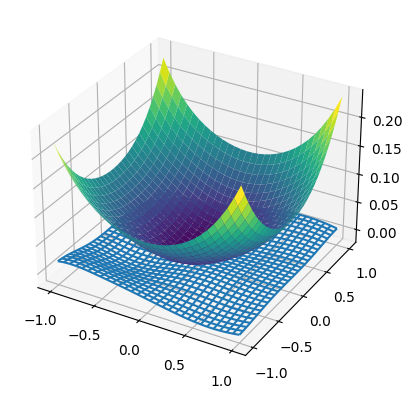

In [14]:
import numpy as np
import matplotlib.pyplot as plt

xr = np.linspace(-1, 1, 30)
yr = np.linspace(-1, 1, 30)

Xm, Ym = np.meshgrid(xr, yr)
Z = np.zeros((30,30))
W = np.zeros((30,30))
V_0 = V(torch.zeros(dim))

for ix,xv in enumerate(xr):
    for iy,yv in enumerate(yr):

        xyv = torch.tensor([xv,yv]).float()
        xyv.requires_grad_(True)
        Z[ix,iy] = torch.square(V(xyv)-V_0)+alpha*torch.sum(torch.square(xyv))
        DV_grad = torch.autograd.grad(V(xyv), xyv, create_graph = True)[0]
        DV_grad =  2*(V(xyv)-V_0)*DV_grad+2*alpha*xyv
        vel = torch.squeeze(F(torch.unsqueeze(xyv,1)))
        W[ix,iy] = torch.dot(DV_grad,vel)
        #Z[ix,iy] = xv*xv+yv*yv

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(Xm, Ym, Z, cmap='viridis', edgecolor='none')
ax.plot_wireframe(Xm, Ym, W)

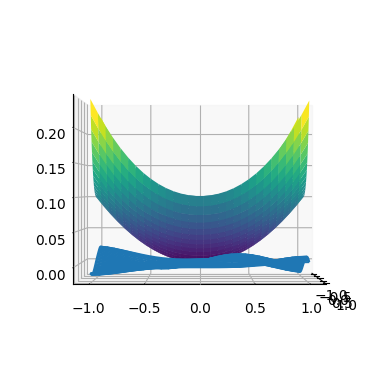

In [15]:
ax.view_init(0,0)
fig

In [16]:
import os

V_0 = V(torch.zeros(dim))
with open(Exp_dir+Datadir, 'a') as f:
      for i in range(N):

        x = (np.random.random_sample()*2-1)*3
        y = (np.random.random_sample()*2-1)*3
        xyv = torch.tensor([x,y]).float()
        xyv.requires_grad_(True)
        z = torch.square(V(xyv)-V_0)+alpha*torch.sum(torch.square(xyv))
        f.write(str(x)+" "+str(y)+" "+str(100*z.detach().numpy()[0]))
        f.write("\n")

In [5]:
import numpy as np

h = 0.001

x = 1
y = 1

X = np.zeros((1000,2))

for i in range(1000):

    X[i] = np.array((x,y))
    x1 = x + h * (y)
    y1 = y + h * (-np.sin(x))
    x = x1
    y = y1

with open(Exp_dir+Datadir, 'a') as f:
    for i in range(1000):

        x = X[i][0]
        y = X[i][1]
        f.write(str(x)+" "+str(y)+" 0")
        f.write("\n")

